# Visualisatie riool data
## Data importeren

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import geopandas as gpd
from datetime import date,datetime,timedelta
from matplotlib.ticker import ScalarFormatter
import numpy as np
from matplotlib.colors import LinearSegmentedColormap, to_rgba_array

In [28]:

sewage_rows = []
for vr in range(1,26):
    sewage_import = pd.read_json("https://coronadashboard.rijksoverheid.nl/json/VR{:02d}.json".format(vr))
    for row in sewage_import['sewer']['values']:
        sewage_rows.append({
            'VR': 'VR{:02d}'.format(vr),
            'Date': pd.to_datetime(row['date_unix'], unit="s"),
            'VirusParts': row['average']
        })

sewer = pd.DataFrame(sewage_rows)
dateOfStats = sewer.Date.max()
sewer

,VR,Date,VirusParts
0,VR01,2020-09-07,NaN
1,VR01,2020-09-08,NaN
2,VR01,2020-09-09,NaN
3,VR01,2020-09-10,NaN
4,VR01,2020-09-11,NaN
...,...,...,...
15945,VR25,2022-06-02,1283.0
15946,VR25,2022-06-03,1283.0
15947,VR25,2022-06-04,1283.0
15948,VR25,2022-06-05,1283.0


In [31]:
vrNames = pd.read_csv('https://raw.githubusercontent.com/mzelst/covid-19/master/misc/nursery-homes-locations.csv').drop(columns=['Aantal_locaties'])
sewer = sewer.join(vrNames.set_index('Security_region_code'), on='VR')
sewer

In [3]:
map_data = gpd.read_file("https://cartomap.github.io/nl/wgs84/veiligheidsregio_2021.geojson")
map_data

,id,statcode,statnaam,jrstatcode,rubriek,FID,geometry
0,VR01,VR01,Groningen,2021VR01,veiligheidsregio,cbs_veiligheidsregio_2021_gegeneraliseerd.1,"MULTIPOLYGON (((7.09300 52.83800, 7.07200 52.8..."
1,VR02,VR02,Fryslân,2021VR02,veiligheidsregio,cbs_veiligheidsregio_2021_gegeneraliseerd.2,"MULTIPOLYGON (((5.10000 53.30100, 5.06300 53.2..."
2,VR03,VR03,Drenthe,2021VR03,veiligheidsregio,cbs_veiligheidsregio_2021_gegeneraliseerd.3,"POLYGON ((6.93700 52.99300, 6.94300 52.98700, ..."
3,VR04,VR04,IJsselland,2021VR04,veiligheidsregio,cbs_veiligheidsregio_2021_gegeneraliseerd.4,"POLYGON ((6.71000 52.62800, 6.72700 52.61500, ..."
4,VR05,VR05,Twente,2021VR05,veiligheidsregio,cbs_veiligheidsregio_2021_gegeneraliseerd.5,"POLYGON ((6.69800 52.48600, 6.75300 52.46400, ..."
5,VR06,VR06,Noord- en Oost-Gelderland,2021VR06,veiligheidsregio,cbs_veiligheidsregio_2021_gegeneraliseerd.6,"POLYGON ((6.09400 52.47400, 6.10200 52.46600, ..."
6,VR07,VR07,Gelderland-Midden,2021VR07,veiligheidsregio,cbs_veiligheidsregio_2021_gegeneraliseerd.7,"POLYGON ((5.47900 52.25800, 5.48400 52.23900, ..."
7,VR08,VR08,Gelderland-Zuid,2021VR08,veiligheidsregio,cbs_veiligheidsregio_2021_gegeneraliseerd.8,"POLYGON ((5.60600 51.94300, 5.63000 51.93600, ..."
8,VR09,VR09,Utrecht,2021VR09,veiligheidsregio,cbs_veiligheidsregio_2021_gegeneraliseerd.9,"POLYGON ((5.02200 52.30200, 5.04300 52.28200, ..."
9,VR10,VR10,Noord-Holland-Noord,2021VR10,veiligheidsregio,cbs_veiligheidsregio_2021_gegeneraliseerd.10,"MULTIPOLYGON (((5.28700 52.69100, 5.28700 52.6..."


## Data voorbereiden

In [33]:
sewer_growth = sewer.copy().groupby(by=['VR', 'Security_region_name']).rolling(on="Date", window=7).mean()
sewer_growth['VirusGrowth_7d'] = sewer_growth.VirusParts.pct_change().replace([np.inf, -np.inf], 0).fillna(0).rolling(window=7).mean() * 100
sewer_growth = sewer_growth.reset_index()
sewer_growth

#sum7d_totals = ageGroupStats.copy().groupby(by=["GGD_name", "Age_group"]).rolling(on="Date", window=7).sum().reset_index()
#sum7d_totals["growth"] = sum7d_totals.Positive_cases.rolling(window=7).sum().pct_change().replace([np.inf, -np.inf], 0).fillna(0).rolling(window=7).mean() * 100
#sum7d_totals


,VR,Security_region_name,level_2,Date,VirusParts,VirusGrowth_7d
0,VR01,Groningen,0,2020-09-07,NaN,NaN
1,VR01,Groningen,1,2020-09-08,NaN,NaN
2,VR01,Groningen,2,2020-09-09,NaN,NaN
3,VR01,Groningen,3,2020-09-10,NaN,NaN
4,VR01,Groningen,4,2020-09-11,NaN,NaN
...,...,...,...,...,...,...
15945,VR25,Flevoland,15945,2022-06-02,1586.000000,16.834031
15946,VR25,Flevoland,15946,2022-06-03,1697.428571,17.936374
15947,VR25,Flevoland,15947,2022-06-04,1826.571429,19.708418
15948,VR25,Flevoland,15948,2022-06-05,1955.714286,20.570916


In [34]:
fallers = sewer_growth[(sewer_growth.Date == dateOfStats) & (sewer_growth.VirusGrowth_7d < -5)].VR.to_list()
risers = sewer_growth[(sewer_growth.Date == dateOfStats) & (sewer_growth.VirusGrowth_7d >= 0)].VR.to_list()

In [35]:
mins = sewer_growth.groupby(by=["Date"]).min()
maxs = sewer_growth.groupby(by=["Date"]).max()
medians = sewer_growth.groupby(by=["Date"]).median()
avg = sewer_growth.groupby(by=["Date"]).mean()
avg["min"] = mins.VirusGrowth_7d
avg["max"] = maxs.VirusGrowth_7d
avg["median"] = medians.VirusGrowth_7d
avg = avg.reset_index()
avg

,Date,level_2,VirusParts,VirusGrowth_7d,min,max,median
0,2020-09-07,7656.0,NaN,7.870557,0.626574,17.466182,7.076898
1,2020-09-08,7657.0,NaN,6.132849,0.230970,16.878595,5.212115
2,2020-09-09,7658.0,NaN,4.426974,-0.690269,11.199582,3.864952
3,2020-09-10,7659.0,NaN,3.280048,-0.839266,7.135978,3.160248
4,2020-09-11,7660.0,NaN,2.183616,-1.096204,5.539266,1.978202
...,...,...,...,...,...,...,...
633,2022-06-02,8289.0,384.537143,3.078824,-7.538784,16.834031,1.606503
634,2022-06-03,8290.0,414.365714,5.131006,-6.039872,19.871614,3.077121
635,2022-06-04,8291.0,445.108571,6.873011,-4.796703,19.708418,5.459510
636,2022-06-05,8292.0,475.268571,7.734291,-3.153320,20.570916,6.566709


## Plots configureren

In [38]:
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1, rc={"lines.linewidth": 3, "font.size":10,"axes.titlesize":24,"axes.labelsize":18})
sns.set_palette(sns.color_palette(['#CC6677', '#332288', '#DDCC77', '#117733', '#88CCEE', \
                    '#882255', '#44AA99', '#999933', '#AA4499', '#DDDDDD', \
                    '#000000']))

def tuftefy(ax):
    """Remove spines and tick position markers to reduce ink."""
    # 
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(True)
    ax.spines["bottom"].set_color('grey')

    ax.grid(color="w", alpha=0.5)
    ax.get_yaxis().grid(True)
    ax.get_xaxis().grid(False)

def fancy_titles(t1, t2, ax=None):
  if ax:
    ax.set_title(t1, loc='left', fontsize=18)
    ax.set_title(t2, loc='right', fontsize=13, color='grey')
  else:
    plt.title(t1, loc='left', fontsize=18)
    plt.title(t2, loc='right', fontsize=13, color='grey')

def __BuRd():
    """
    Define colormap 'BuRd'.
    """
    clrs = ['#2166AC', '#4393C3', '#92C5DE', '#D1E5F0', '#F7F7F7',
            '#FDDBC7', '#F4A582', '#D6604D', '#B2182B']
    return LinearSegmentedColormap.from_list('BuRd', clrs)

## Plots

### Trends

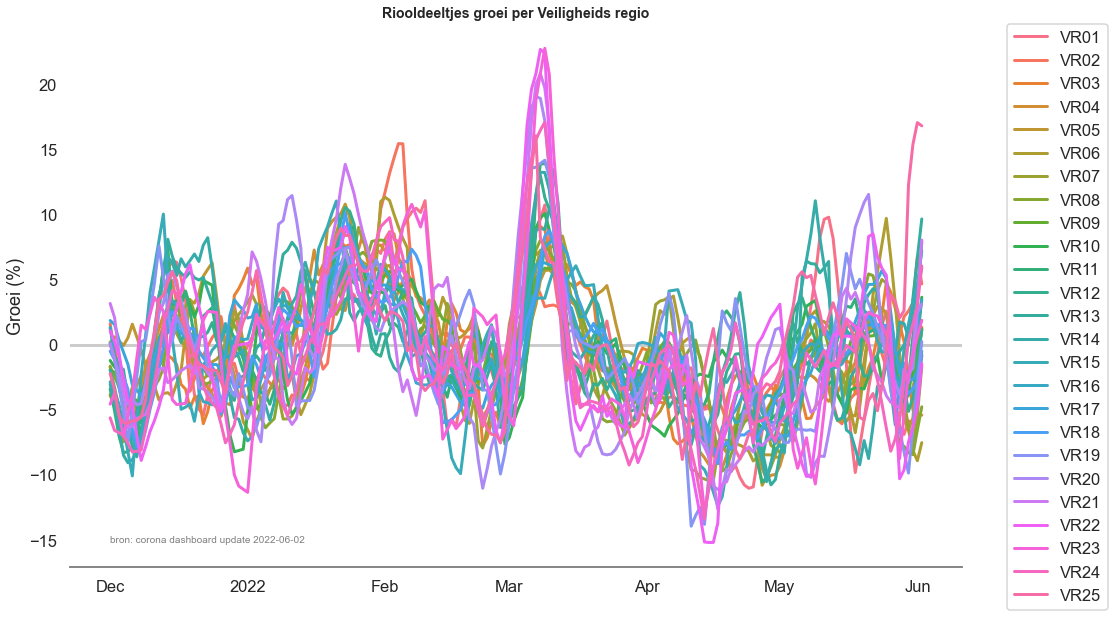

In [8]:
fig = plt.figure()
fig.set_size_inches(16, 10)

dt = sewer_growth[sewer_growth.Date > '2021-11-30']
g = sns.lineplot(data=dt, x='Date', y='VirusGrowth_7d', hue='VR')
plt.axhline(y=0.0, ls='-', c='.8', zorder=1)
tuftefy(g)
g.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
g.set_title("Riooldeeltjes groei per Veiligheids regio", fontdict={'fontsize':14,'fontweight': 'bold'})
g.set(xlabel="", ylabel="Groei (%)")
g.text(dt.Date.min(), dt.VirusGrowth_7d.min(), "bron: corona dashboard update " + dateOfStats.strftime('%Y-%m-%d'), ha="left", fontsize=10, color='grey')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

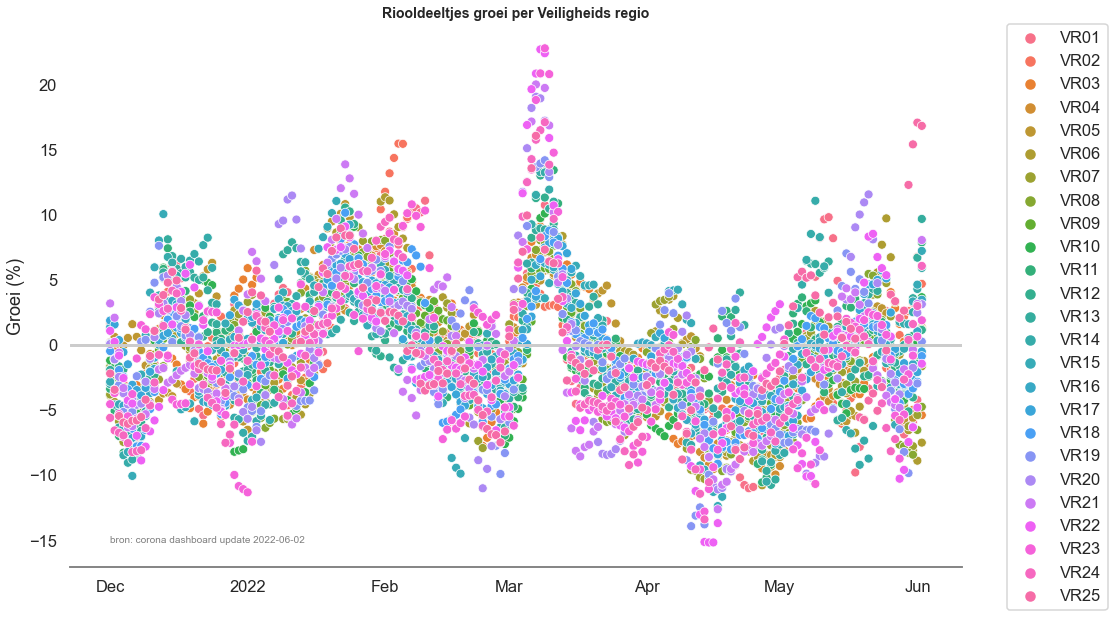

In [9]:
fig = plt.figure()
fig.set_size_inches(16, 10)

dt = sewer_growth[sewer_growth.Date > '2021-11-30']
g = sns.scatterplot(data=dt, x='Date', y='VirusGrowth_7d', hue='VR')
plt.axhline(y=0.0, ls='-', c='.8', zorder=1)
tuftefy(g)
g.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
g.set_title("Riooldeeltjes groei per Veiligheids regio", fontdict={'fontsize':14,'fontweight': 'bold'})
g.set(xlabel="", ylabel="Groei (%)")
g.text(dt.Date.min(), dt.VirusGrowth_7d.min(), "bron: corona dashboard update " + dateOfStats.strftime('%Y-%m-%d'), ha="left", fontsize=10, color='grey')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

Text(2022-01-01 00:00:00, -15.195840855386727, 'bron: corona dashboard update 2022-06-02')

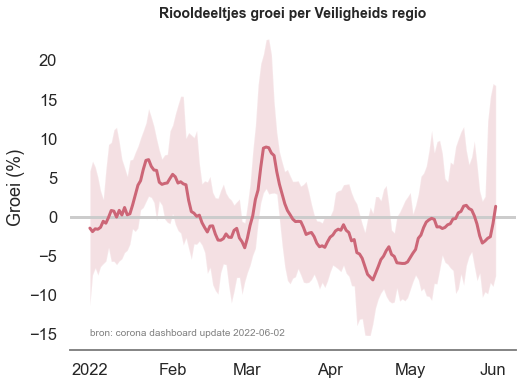

In [10]:
fig = plt.figure()
fig.set_size_inches(8, 6)
dt = avg[avg.Date > '2021-12-31']
g = sns.lineplot(data=dt, x='Date', y='median')
plt.fill_between(data=dt, x='Date', y1='min', y2='max',zorder=1, alpha=0.2)
plt.axhline(y=0.0, ls='-', c='.8', zorder=1)
tuftefy(g)
g.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
g.set_title("Riooldeeltjes groei per Veiligheids regio", fontdict={'fontsize':14,'fontweight': 'bold'})
g.set(xlabel="", ylabel="Groei (%)")
g.text(dt.Date.min(), dt['min'].min(), "bron: corona dashboard update " + dateOfStats.strftime('%Y-%m-%d'), ha="left", fontsize=10, color='grey')

Text(2021-12-01 00:00:00, -13.676256769848054, 'bron: corona dashboard update 2022-06-02')

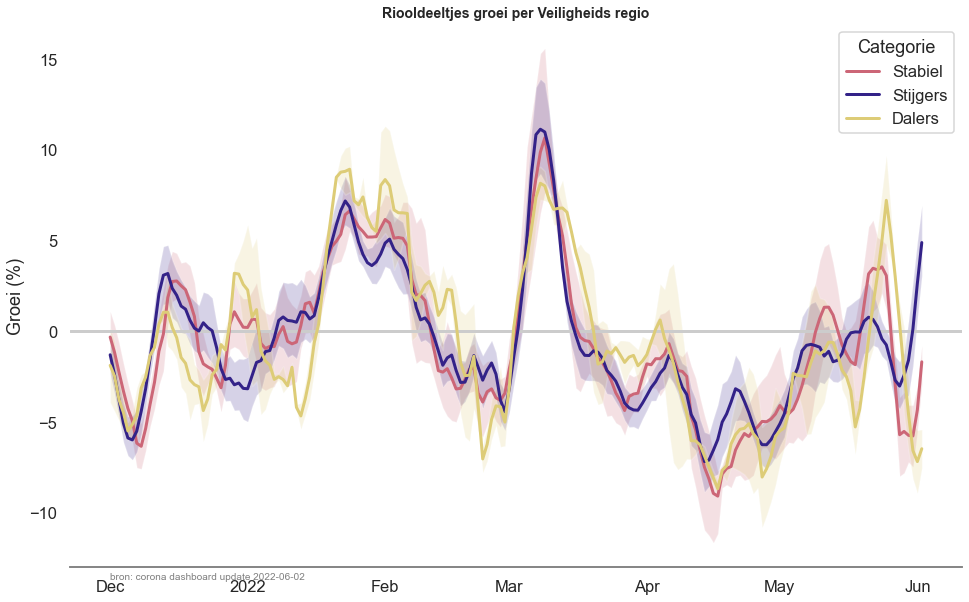

In [11]:
fig = plt.figure()
fig.set_size_inches(16, 10)

dt = sewer_growth[sewer_growth.Date > '2021-11-30'].copy()
dt['Categorie'] = 'Stabiel'
dt.loc[dt.VR.isin(fallers), 'Categorie'] = 'Dalers'
dt.loc[dt.VR.isin(risers), 'Categorie'] = 'Stijgers'
#dt['Categorie'] = np.where(dt.VR.isin(fallers), 'Dalers', 'Stijgers')
g = sns.lineplot(data=dt, x='Date', y='VirusGrowth_7d', hue='Categorie', ci=95, err_kws={ "edgecolor" : None })
plt.axhline(y=0.0, ls='-', c='.8', zorder=1)
tuftefy(g)
g.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
g.set_title("Riooldeeltjes groei per Veiligheids regio", fontdict={'fontsize':14,'fontweight': 'bold'})
g.set(xlabel="", ylabel="Groei (%)")
g.text(dt.Date.min(), dt.VirusGrowth_7d.min() * 0.9, "bron: corona dashboard update " + dateOfStats.strftime('%Y-%m-%d'), ha="left", fontsize=10, color='grey')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

Text(2021-12-01 00:00:00, -13.676256769848054, 'bron: corona dashboard update 2022-06-02')

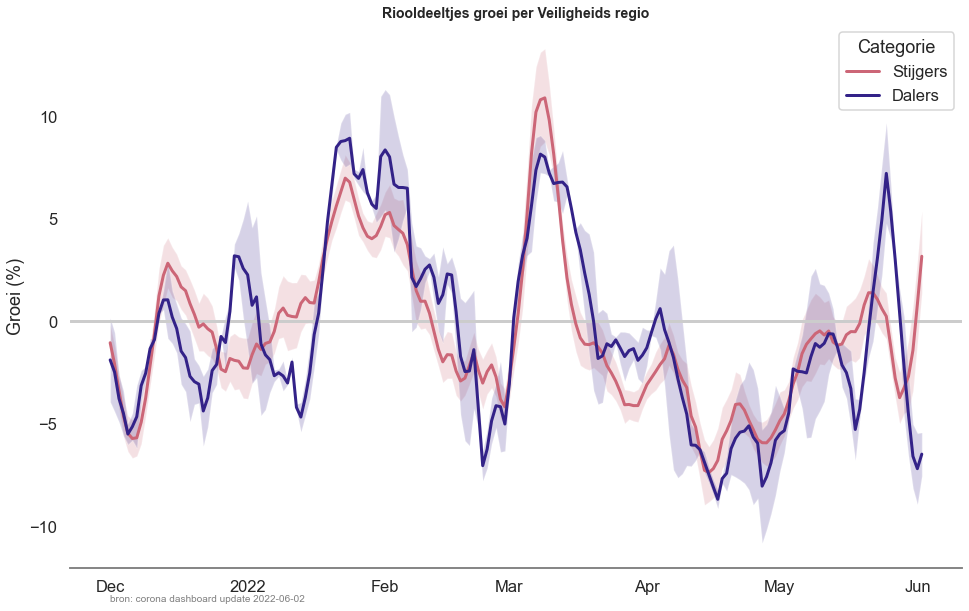

In [12]:

fig = plt.figure()
fig.set_size_inches(16, 10)

dt = sewer_growth[sewer_growth.Date > '2021-11-30'].copy()
dt['Categorie'] = 'Stijgers'
dt.loc[dt.VR.isin(fallers), 'Categorie'] = 'Dalers'
#dt['Categorie'] = np.where(dt.VR.isin(fallers), 'Dalers', 'Stijgers')
g = sns.lineplot(data=dt, x='Date', y='VirusGrowth_7d', hue='Categorie', ci=95, err_kws={ "edgecolor" : None })
plt.axhline(y=0.0, ls='-', c='.8', zorder=1)
tuftefy(g)
g.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
g.set_title("Riooldeeltjes groei per Veiligheids regio", fontdict={'fontsize':14,'fontweight': 'bold'})
g.set(xlabel="", ylabel="Groei (%)")
g.text(dt.Date.min(), dt.VirusGrowth_7d.min() * 0.9, "bron: corona dashboard update " + dateOfStats.strftime('%Y-%m-%d'), ha="left", fontsize=10, color='grey')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

Text(2021-01-01 00:00:00, -20.570618883438605, 'bron: corona dashboard update 2022-06-02')

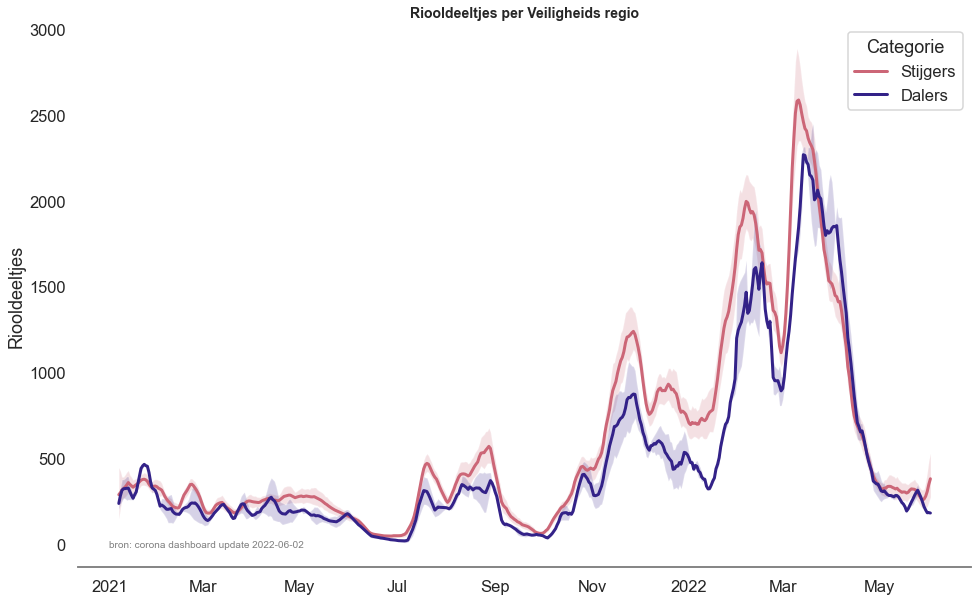

In [13]:

fig = plt.figure()
fig.set_size_inches(16, 10)

dt = sewer_growth[sewer_growth.Date > '2020-12-31'].copy()
dt['Categorie'] = 'Stijgers'
dt.loc[dt.VR.isin(fallers), 'Categorie'] = 'Dalers'
#dt['Categorie'] = np.where(dt.VR.isin(fallers), 'Dalers', 'Stijgers')
g = sns.lineplot(data=dt, x='Date', y='VirusParts', hue='Categorie', ci=95, err_kws={ "edgecolor" : None })
#plt.axhline(y=0.0, ls='-', c='.8', zorder=1)
tuftefy(g)
g.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
g.set_title("Riooldeeltjes per Veiligheids regio", fontdict={'fontsize':14,'fontweight': 'bold'})
g.set(xlabel="", ylabel="Riooldeeltjes")
g.text(dt.Date.min(), dt.VirusGrowth_7d.min() * 0.9, "bron: corona dashboard update " + dateOfStats.strftime('%Y-%m-%d'), ha="left", fontsize=10, color='grey')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

Text(2021-01-01 00:00:00, -20.570618883438605, 'bron: corona dashboard update 2022-06-02')

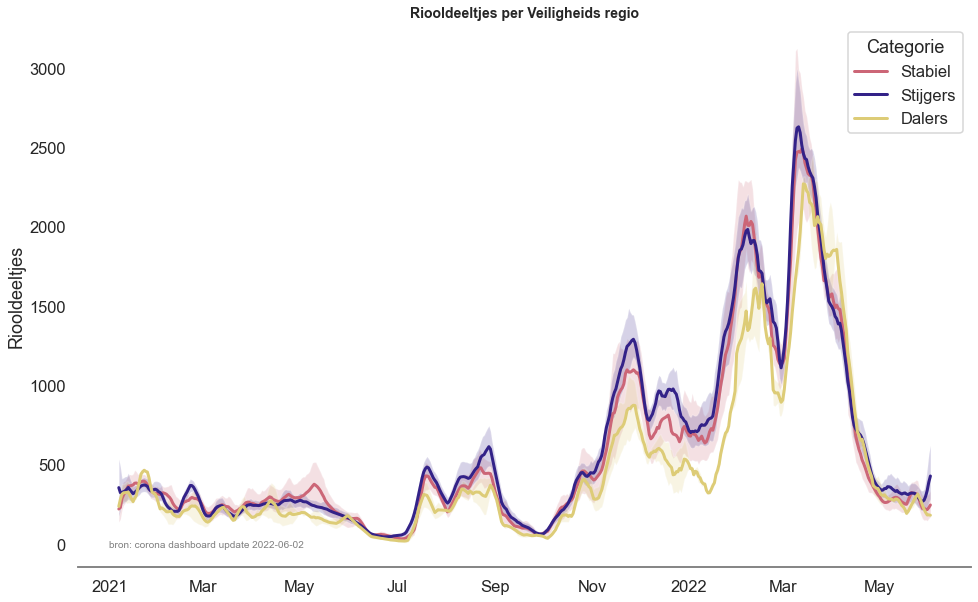

In [14]:

fig = plt.figure()
fig.set_size_inches(16, 10)

dt = sewer_growth[sewer_growth.Date > '2020-12-31'].copy()
dt['Categorie'] = 'Stabiel'
dt.loc[dt.VR.isin(fallers), 'Categorie'] = 'Dalers'
dt.loc[dt.VR.isin(risers), 'Categorie'] = 'Stijgers'
#dt['Categorie'] = np.where(dt.VR.isin(fallers), 'Dalers', 'Stijgers')
g = sns.lineplot(data=dt, x='Date', y='VirusParts', hue='Categorie', ci=95, err_kws={ "edgecolor" : None })
#plt.axhline(y=0.0, ls='-', c='.8', zorder=1)
tuftefy(g)
g.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
g.set_title("Riooldeeltjes per Veiligheids regio", fontdict={'fontsize':14,'fontweight': 'bold'})
g.set(xlabel="", ylabel="Riooldeeltjes")
g.text(dt.Date.min(), dt.VirusGrowth_7d.min() * 0.9, "bron: corona dashboard update " + dateOfStats.strftime('%Y-%m-%d'), ha="left", fontsize=10, color='grey')
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

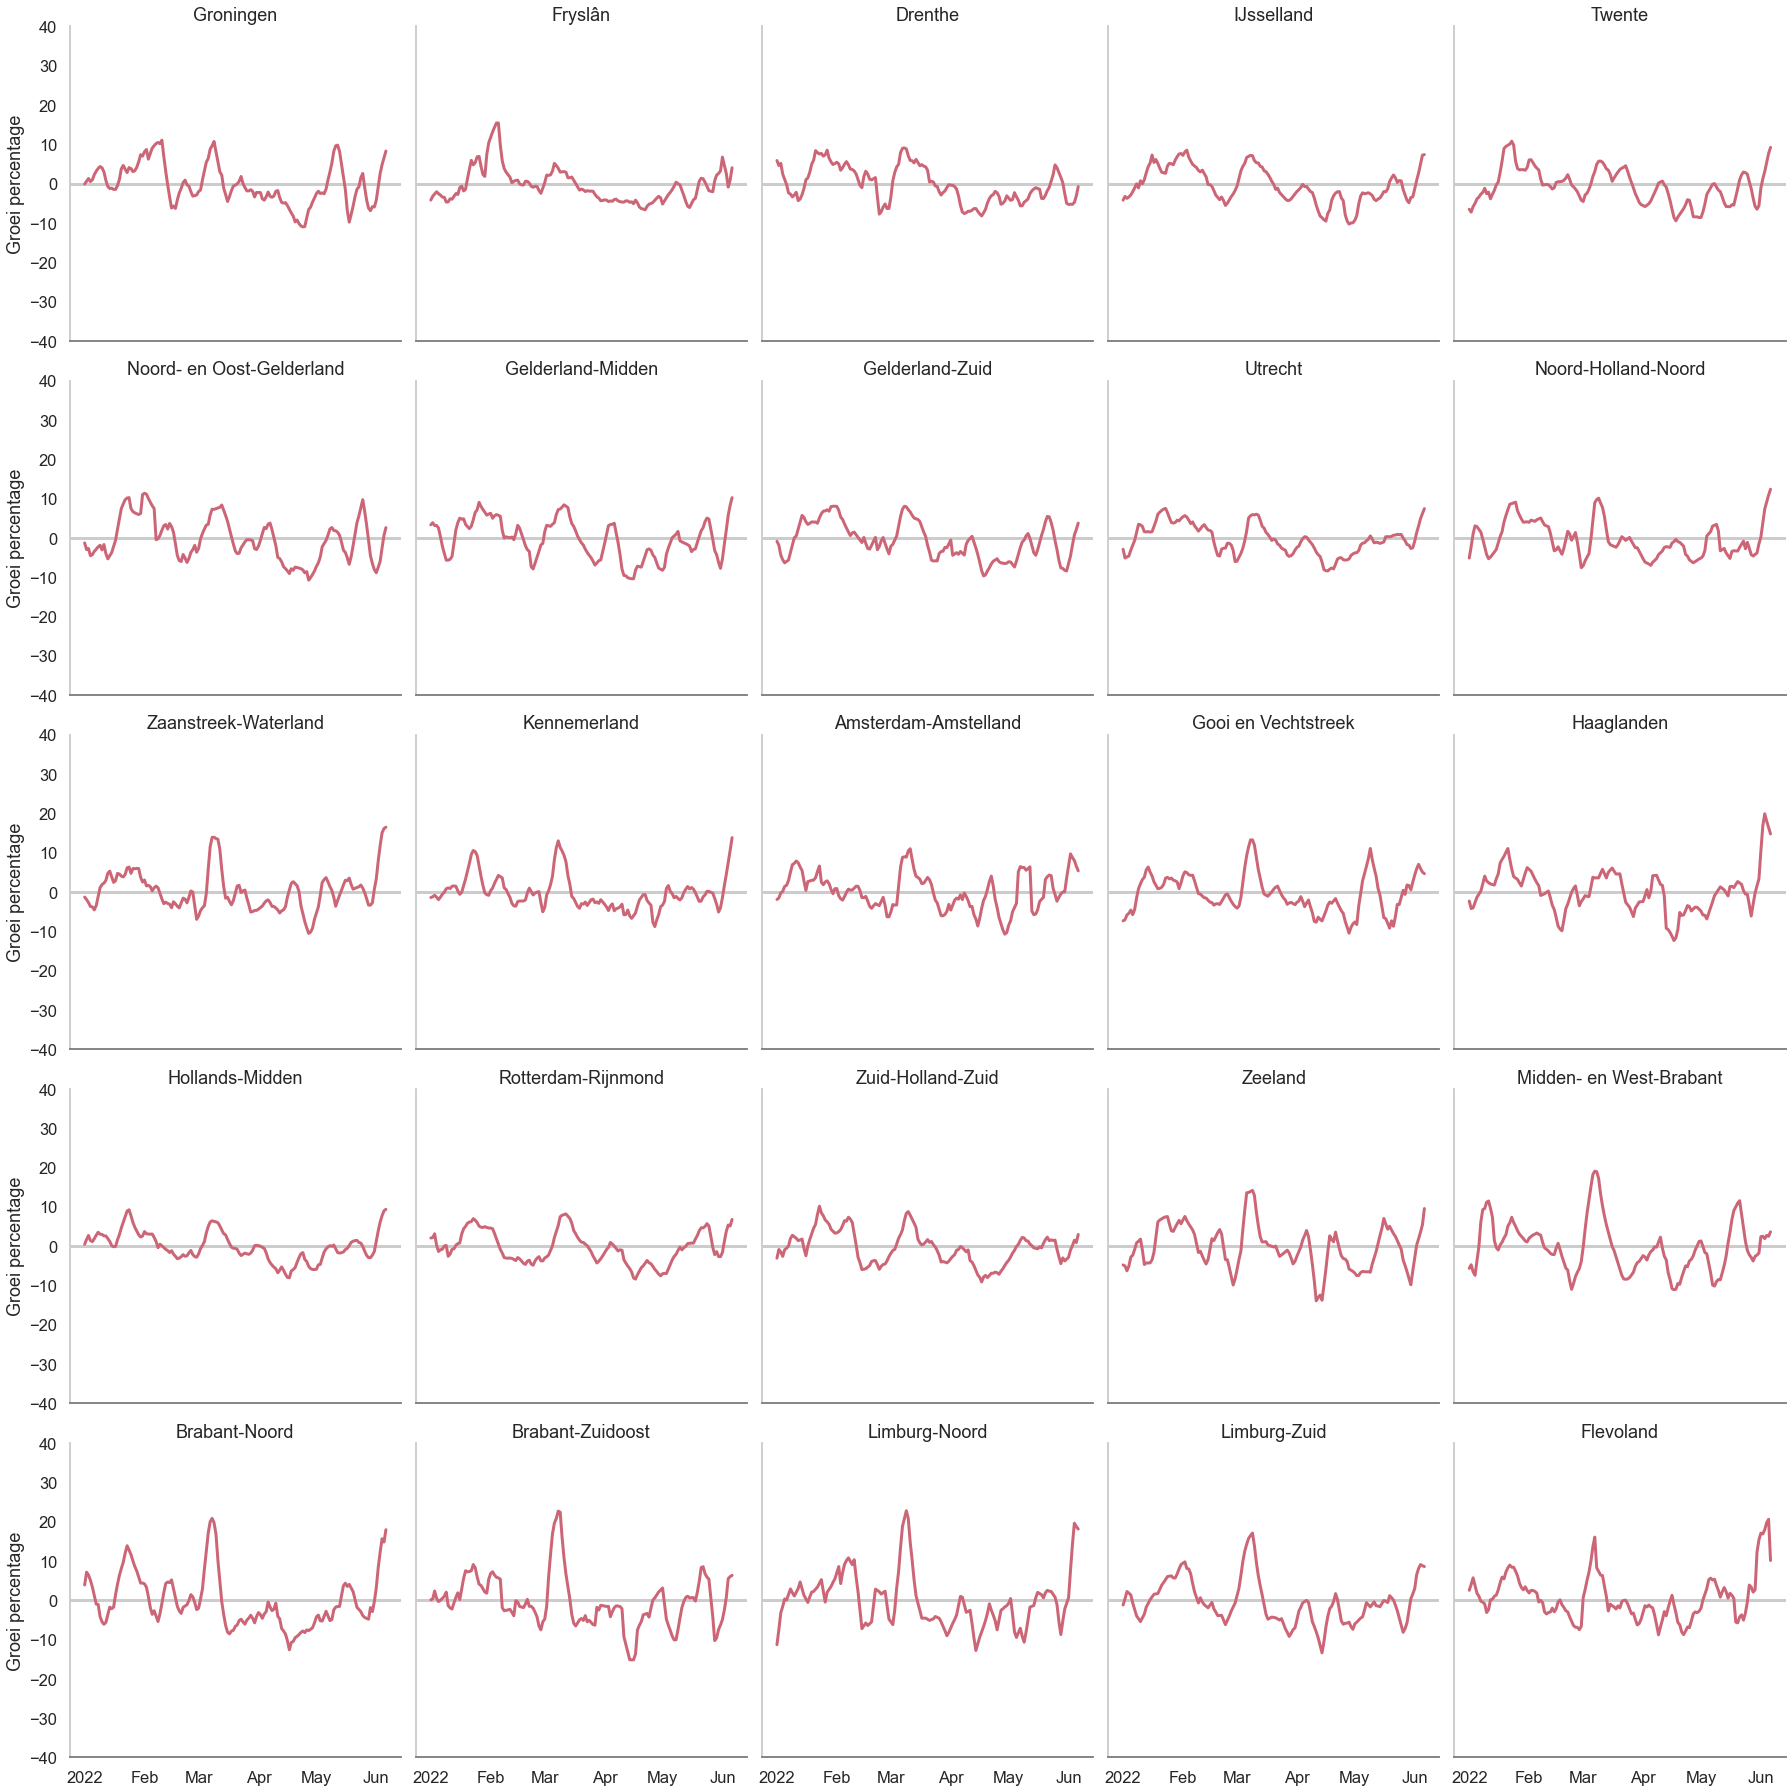

In [37]:

#fig = plt.figure()
#fig.set_size_inches(16, 10)

dt = sewer_growth[sewer_growth.Date > '2021-12-31'].copy()

g = sns.relplot(data=dt, kind='line', x='Date', y ='VirusGrowth_7d', col='Security_region_name', col_wrap=5)
g = g.map(plt.axhline, y=0.0, ls="-", c=".8", zorder=1)

for ax in g.axes:
  ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
  ax.set(ylim=[-40, 40])
  tuftefy(ax)

g.set_titles(col_template = '{col_name}')
g.set_axis_labels("", "Groei percentage")
g.despine()
plt.tight_layout()

#dt['Categorie'] = 'Stabiel'
#dt.loc[dt.VR.isin(fallers), 'Categorie'] = 'Dalers'
#dt.loc[dt.VR.isin(risers), 'Categorie'] = 'Stijgers'
##dt['Categorie'] = np.where(dt.VR.isin(fallers), 'Dalers', 'Stijgers')
#g = sns.lineplot(data=dt, x='Date', y='VirusParts', hue='Categorie', ci=95, err_kws={ "edgecolor" : None })
##plt.axhline(y=0.0, ls='-', c='.8', zorder=1)
#tuftefy(g)
#g.xaxis.set_major_formatter(mdates.ConciseDateFormatter(mdates.AutoDateLocator()))
#g.set_title("Riooldeeltjes per Veiligheids regio", fontdict={'fontsize':14,'fontweight': 'bold'})
#g.set(xlabel="", ylabel="Riooldeeltjes")
#g.text(dt.Date.min(), dt.VirusGrowth_7d.min() * 0.9, "bron: corona dashboard update " + dateOfStats.strftime('%Y-%m-%d'), ha="left", fontsize=10, color='grey')
##plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

## Kaartjes

Text(0.5, 1.0, 'Groei riooldeeltjes')

<Figure size 720x1152 with 0 Axes>

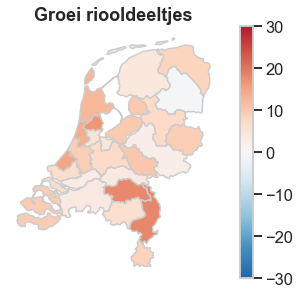

In [54]:
annotated_map = map_data.copy().set_index('statcode').join(sewer_growth[sewer_growth.Date == sewer_growth.Date.max()].copy().set_index('VR'), how='left')

g = annotated_map.plot("VirusGrowth_7d", cmap=__BuRd(), vmin=-30, vmax=30, edgecolor="#cccccc", legend=True)
g.set_axis_off()
plt.tight_layout()

g.set_title("Groei riooldeeltjes", fontdict={'fontsize':18,'fontweight': 'bold'})
#g.set(xlabel="", ylabel="Riooldeeltjes")
#g.text(dt.Date.min(), dt.VirusGrowth_7d.min() * 0.9, "bron: corona dashboard update " + dateOfStats.strftime('%Y-%m-%d'), ha="left", fontsize=8, color='grey')

#g = sns.FacetGrid(annotated_map, col="Security_region_name", col_wrap=4, margin_titles=True, legend_out=True)
#def map_plot(data, **kws):
#    ax = plt.gca()
#    data.plot("VirusGrowth_7d", cmap=__BuRd(), ax= ax, vmin=-100, vmax=100, edgecolor="#cccccc", legend=True)
#    ax.set_axis_off()
#
#
#g = g.map_dataframe(map_plot)
#
#g.set_titles(col_template = '{col_name}')
#g.add_legend(loc='upper right')
#
#g.despine()
#plt.tight_layout()
#plt.subplots_adjust(hspace=0.1, wspace=0.05, top=0.93)
#g.fig.suptitle('Groei percentage deeltjes in riool (7d gemiddelde)', size=16.0, weight='bold')
#g.fig.text(1,0.03, "bron: RIVM update " + dateOfStats.strftime('%Y-%m-%d') + " & CBS statistiek", ha="right", fontsize=12, color='grey')

